# Genre Classification
## Introduction

Over the past few years, text classification has emerged as a cornerstone task in Natural Language Processing (NLP). A notable use case is automatically identifying a film’s genre from its plot synopsis. Reliable genre prediction streamlines content discovery, simplifies media cataloguing, and powers recommendation engines.

In this project, we explore a spectrum of techniques for genre classification, from traditional machine learning algorithms to cutting edge deep learning architectures.


## Agenda

The structure of this report is as follows:

1. **Introduction**  
   Motivation and objectives of the project.

2. **Dataset Preparation**  
   Description of the dataset and the preprocessing steps used to reduce multi-genre labels to a single main genre.

3. **Classical Machine Learning Models**  
   Implementation and evaluation of traditional models including:
   - Support Vector Machines (SVM)
   - Logistic Regression
   - Random Forest Classifier

4. **LSTM Model**  
   Construction and tuning of a neural network based on Long Short-Term Memory units for genre classification.

5. **BERT Classification Model**  
   Application of a pre-trained BERT model fine-tuned for the task of classifying movie descriptions by genre.

7. **Conclusion**  
   Summary of findings and discussion of potential improvements and future work.


In [5]:
# Standard Libraries
from collections import defaultdict
from itertools import combinations
import re

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Transformers
from transformers import (AutoTokenizer,
                          TFAutoModelForSequenceClassification,
                          BertTokenizer,
                          BertForSequenceClassification,
                          AutoModelForSequenceClassification,
                          DataCollatorWithPadding,
                          get_scheduler)

# TensorFlow/Keras
from tensorflow.keras import (layers, Sequential, optimizers,
                              callbacks, preprocessing, regularizers)
from keras_tuner import RandomSearch
from keras.src.layers import BatchNormalization
from transformers import create_optimizer
from keras.src.legacy.preprocessing.text import Tokenizer

# Other
from tqdm import tqdm
from datasets import Dataset
from google.colab import drive

In [6]:

drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Preparation

The goal of this stage is to load and preprocess the dataset in a way that ensures the relevant information is cleanly structured and ready for supervised learning.


In [7]:
df_wiki = pd.read_json('/content/drive/MyDrive/merged_wiki_plot.json', lines=True)

### Genre Simplification


In [8]:
df_wiki["genres"].head(5)

,genres
0,Adventure-Action-Science Fiction
1,Animation-Family-Adventure-Drama-Comedy
2,Adventure-Family-Fantasy
3,Action-Thriller-Crime
4,Action-Adventure-Fantasy-Science Fiction


In [9]:
df_wiki["sorted_genres"] = df_wiki["genres"].str.split("-").apply(lambda x: "-".join(sorted(x)))
amount_combinations = df_wiki["sorted_genres"].nunique()
print(f"There are {amount_combinations} different genre-combinations")

There are 1210 different genre-combinations


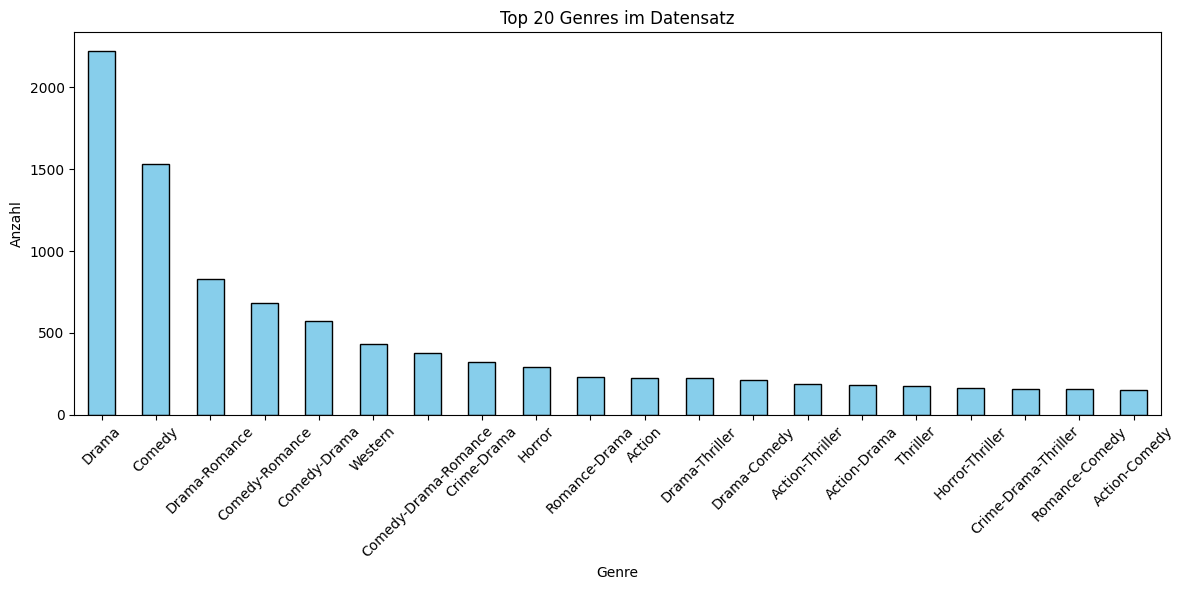

In [10]:
def plot_top_genres(genres, top_n=20):
    genre_counts = genres.explode().value_counts().head(top_n)
    plt.figure(figsize=(12, 6))
    genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top {top_n} Genres im Datensatz")
    plt.xlabel("Genre")
    plt.ylabel("Anzahl")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



genre_series = df_wiki["genres"]
plot_top_genres(genre_series)


The `genres` column contains multiple genre labels for each movie, joined together by hyphens.
This format presents a challenge for classification, as it represents a **multi-label problem**, where each sample can belong to several genre categories simultaneously. Multi-label classification typically requires specialized models and loss functions, and increases the complexity of training and evaluation.

Moreover, the dataset contains **more than 1,200 unique genre combinations**, many of which appear only a few times. This extreme label sparsity results in an imbalanced dataset, where most classes would have insufficient training examples to learn meaningful patterns.

To address these issues and simplify the task, we reduce each genre string to a **single main genre**. This transformation allows us to reframe the problem as a **multi-class classification** task, enabling the use of standard classification models and evaluation procedures while ensuring that each class has a sufficient number of training samples.


A method has been developed to filter the dataset so that as many genres as possible are retained, while including only those genres that contain at least 1,000 films and whose film sets do not overlap.

Gültige Genres (mind. 1000 Filme, ohne {}): {'Comedy', 'Drama'}
Beste Genre-Kombination ohne Konflikt & ohne {}: {'Comedy', 'Drama'}
Gesamtanzahl Filme: 3759


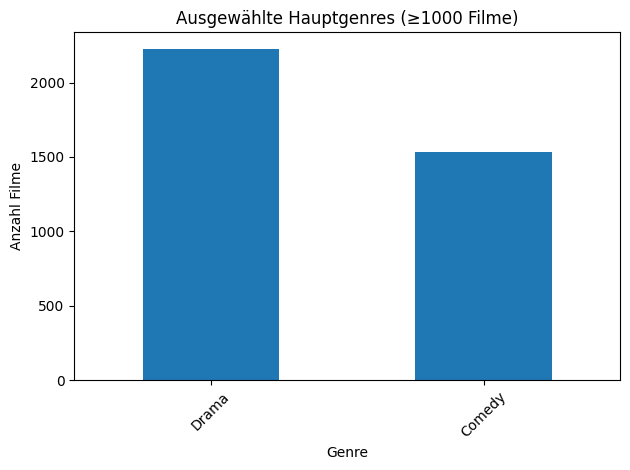

In [11]:
def filter_genres_disjoint(df, min_films=1000, max_genres=8, exclude_genres={}):
    df = df.copy()
    df["genre_list"] = df["genres"].apply(lambda x: x.split("-"))

    df["is_single"] = df["genre_list"].apply(lambda x: len(x) == 1)
    single_genre_df = df[df["is_single"]].copy()
    single_genre_df["main_genre"] = single_genre_df["genre_list"].str[0]

    genre_to_ids = defaultdict(set)
    for idx, row in single_genre_df.iterrows():
        genre = row["main_genre"]
        genre_to_ids[genre].add(idx)

    valid_genres = {g for g, ids in genre_to_ids.items()
                    if len(ids) >= min_films and g not in exclude_genres}
    print(f"Gültige Genres (mind. {min_films} Filme, ohne {exclude_genres}): {valid_genres}")

    best_combo = set()
    best_total = 0

    for r in range(2, max_genres + 1):
        for combo in combinations(valid_genres, r):
            all_ids = set()
            conflict = False
            for g in combo:
                if not all_ids.isdisjoint(genre_to_ids[g]):
                    conflict = True
                    break
                all_ids.update(genre_to_ids[g])
            if not conflict and len(combo) > len(best_combo):
                best_combo = set(combo)
                best_total = len(all_ids)

    print(f"Beste Genre-Kombination ohne Konflikt & ohne {exclude_genres}: {best_combo}")
    print(f"Gesamtanzahl Filme: {best_total}")

    filtered_df = single_genre_df[single_genre_df["main_genre"].isin(best_combo)].copy()
    return filtered_df


df_cleaned = filter_genres_disjoint(df_wiki)
df_cleaned["main_genre"].value_counts().plot(kind="bar", title="Ausgewählte Hauptgenres (≥1000 Filme)")
plt.xlabel("Genre")
plt.ylabel("Anzahl Filme")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


With this approach, we end up with only 2 genres, which is too few for our purposes. Therefore, we decided to omit the comparison of whether the longer Wikipedia plot performs better than the shorter Overview. Instead of using the smaller merged Wikipedia dataset, we chose to train the classification model solely on the Overview dataset and use the larger dataset containing over 500,000 films.

In [12]:
df_all = pd.read_json('/content/drive/MyDrive/all_data.json', lines=True)
df_all.dropna(subset=["overview", "genres"], inplace=True)
df_all = df_all[df_all['overview'].str.len() >= 200]

df_all['overview_length'] = df_all['overview'].str.len()
shortest_overviews = df_all.nsmallest(10, 'overview_length')
print(shortest_overviews[['overview', 'overview_length']])

                                               overview  overview_length
570   Having grown sick and tired of his centuries a...              200
683   Sophie a young milliner is turned into an elde...              200
1552  Frustrated by scrolling dating apps only to en...              200
1775  Chaos reigns at the natural history museum whe...              200
2289  Playing around while aboard a cruise ship the ...              200
2382  19-year-old Linnéa leaves her small town in Sw...              200
2449  Set in 1879 Paris. An orphan girl dreams of be...              200
2766  On the fifteenth anniversary of the exorcism t...              200
2890  A cooler-than-ever Bruce Wayne must deal with ...              200
3043  In 1969 young Jud Crandall has dreams of leavi...              200


<ipython-input-12-a9f9cc880093>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['overview_length'] = df_all['overview'].str.len()


Gültige Genres (mind. 5000 Filme, ohne {}): {'Animation', 'Comedy', 'Drama', 'Music', 'Documentary'}
Beste Genre-Kombination ohne Konflikt & ohne {}: {'Animation', 'Comedy', 'Drama', 'Music', 'Documentary'}
Gesamtanzahl Filme: 91156


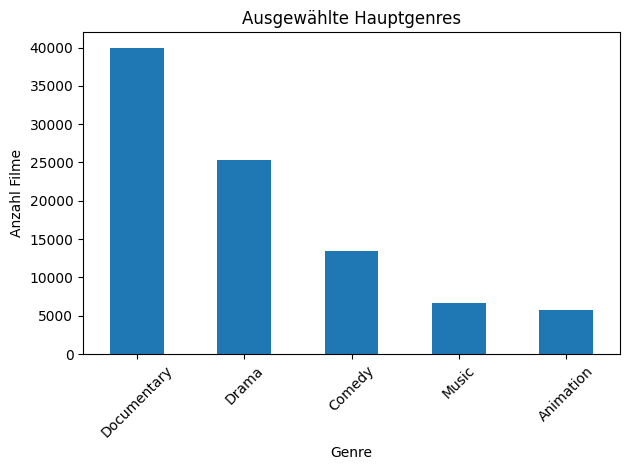

In [13]:
df_all_cleaned = filter_genres_disjoint(df_all, min_films=5000)
df_all_cleaned["main_genre"].value_counts().plot(kind="bar", title="Ausgewählte Hauptgenres")
plt.xlabel("Genre")
plt.ylabel("Anzahl Filme")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We applied the same procedure to the larger dataset, this time including all genres with more than 5,000 training samples. The result shows that the genres `{'Animation', 'Comedy', 'Drama', 'Music', 'Documentary'}` have sufficient training data to effectively train our models.


In [15]:
df_limited = (
    df_all_cleaned.groupby("main_genre", group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), 6000), random_state=42))
    .reset_index(drop=True)
)


print(df_limited["main_genre"].value_counts())

main_genre
Comedy         6000
Drama          6000
Documentary    6000
Music          6000
Animation      5713
Name: count, dtype: int64


<ipython-input-15-e53b9c67eacb>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), 6000), random_state=42))


Imbalanced data distributions in machine learning tasks can negatively affect model performance, as models tend to be biased towards classes with more training samples. To mitigate this issue, we balance the dataset by limiting each class to a maximum of 6,000 training samples.

In [26]:
main_genres = {'Animation', 'Comedy', 'Drama', 'Music', 'Documentary'}
pattern = re.compile('|'.join(re.escape(genre) for genre in main_genres), flags=re.IGNORECASE)

def remove_genre_parts(text):
    return pattern.sub('', text)

df_limited['overview'] = df_limited['overview'].apply(remove_genre_parts)


To prevent the models from simply learning to identify genres based on explicit mentions within the text data, we remove all genre-related words from the `overview` and `plot` fields. Using a regular expression pattern that matches the main genres (`Music`, `Animation`, `Comedy`, `Documentary`, `Drama`), we substitute these genre words with an empty string, effectively eliminating direct genre cues from the textual inputs.


## Classical Machine Learning Models

In this section, we apply traditional machine learning models to the genre classification task. All models use TF-IDF vectorization to convert text into numerical feature representations. We evaluate the performance of each model using a train/test split and optimize them via grid search with 3-fold cross-validation.

The models used are:

- **Logistic Regression**: Computes a weighted sum of input features and applies the logistic (sigmoid) function to estimate class probabilities. It learns the weights by minimizing a loss function through optimization.
  
- **Random Forest**: Builds an ensemble of decision trees, each trained on a random subset of the data and features. The final prediction is made by aggregating the predictions of all trees.

- **Support Vector Machine (SVM)**: Finds the optimal hyperplane that maximally separates classes in a high-dimensional feature space. In our case, we use a linear kernel, meaning the model attempts to draw straight-line boundaries between classes.

Each model is wrapped in a scikit-learn `Pipeline` along with a `TfidfVectorizer`. We test the models on the `overview` text data and visualize their accuracy and confusion matrices to assess their classification performance.



Training Logistic Regression
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters for LogisticRegression:
{'clf__C': 1, 'clf__solver': 'lbfgs', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
Test accuracy: 0.7402



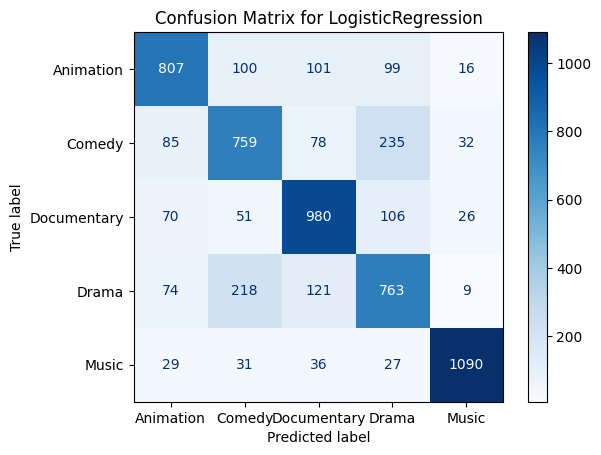


Top 3 misclassifications for Logistic Regression:
   true_genre predicted_genre  count
6      Comedy           Drama    235
13      Drama          Comedy    218
14      Drama     Documentary    121

Misclassification: Comedy -> Drama (235 cases)

Example 1:
Text: A melodrama about the blossoming love between two  students returning home from abroad and planning to wed.  However both of their parents don't know ...
True: Comedy | Predicted: Drama

Example 2:
Text: Filli and the cavemen from "When Women Had Tails" are living a carefree life inside a dinosaur skeleton. But when conman Ham introduces them to the co...
True: Comedy | Predicted: Drama

Example 3:
Text: Florence and Vincent Leroy are a model couple. They have great jobs a perfect marriage and delightful children. And now they want their divorce to be ...
True: Comedy | Predicted: Drama

Misclassification: Drama -> Comedy (218 cases)

Example 1:
Text: In the late 1950s and early '60s artist Walter Keane achieves unbelievable 

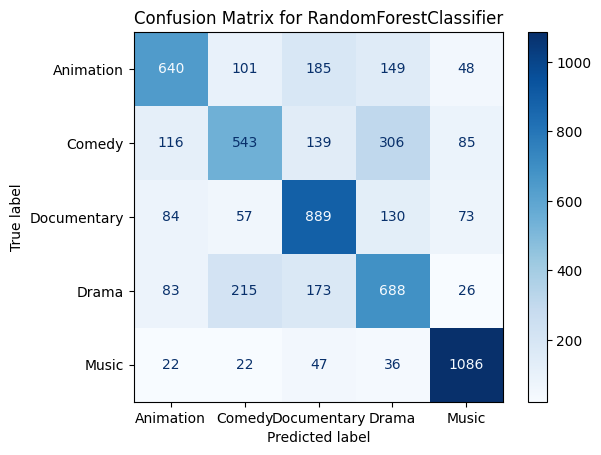


Top 3 misclassifications for Random Forest:
   true_genre predicted_genre  count
6      Comedy           Drama    306
13      Drama          Comedy    215
1   Animation     Documentary    185

Misclassification: Comedy -> Drama (306 cases)

Example 1:
Text: Filli and the cavemen from "When Women Had Tails" are living a carefree life inside a dinosaur skeleton. But when conman Ham introduces them to the co...
True: Comedy | Predicted: Drama

Example 2:
Text: Isidoor lives with his niece and a housekeeper in a little provincial town. One day he receives a letter: he is to be the heir of a distant and wealth...
True: Comedy | Predicted: Drama

Example 3:
Text: Florence and Vincent Leroy are a model couple. They have great jobs a perfect marriage and delightful children. And now they want their divorce to be ...
True: Comedy | Predicted: Drama

Misclassification: Drama -> Comedy (215 cases)

Example 1:
Text: In the late 1950s and early '60s artist Walter Keane achieves unbelievable fame a

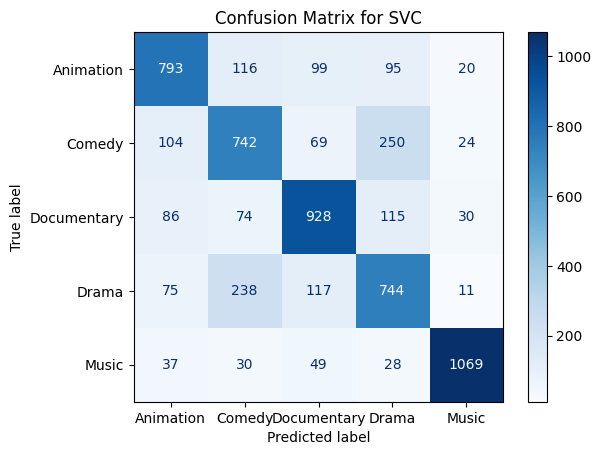


Top 3 misclassifications for SVM:
   true_genre predicted_genre  count
6      Comedy           Drama    250
13      Drama          Comedy    238
14      Drama     Documentary    117

Misclassification: Comedy -> Drama (250 cases)

Example 1:
Text: A melodrama about the blossoming love between two  students returning home from abroad and planning to wed.  However both of their parents don't know ...
True: Comedy | Predicted: Drama

Example 2:
Text: Filli and the cavemen from "When Women Had Tails" are living a carefree life inside a dinosaur skeleton. But when conman Ham introduces them to the co...
True: Comedy | Predicted: Drama

Example 3:
Text: Caught in a 5th Avenue traffic jam as they are riding in side-by-side taxicab and limousine Jack Benny (Jack Benny) and Helen Hunt (Francetta Malloy) ...
True: Comedy | Predicted: Drama

Misclassification: Drama -> Comedy (238 cases)

Example 1:
Text: Selma and Sinan are a couple who now find it difficult to endure each other. At the end of 

In [24]:
def train_traditional_model(clf, params, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('clf', clf)
    ])

    gs = GridSearchCV(pipeline, params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)

    print(f"\nBest parameters for {clf.__class__.__name__}:")
    print(gs.best_params_)

    y_pred = gs.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {acc:.4f}\n")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {clf.__class__.__name__}')
    plt.show()

    misclassified_mask = (y_test != y_pred)

    return gs.best_estimator_, acc, misclassified_mask, y_pred, X_test, y_test


X_overview = df_limited["overview"]
y = df_limited["main_genre"]
X_train_overview, X_test_overview, y_train_overview, y_test_overview = train_test_split(
    X_overview, y, test_size=0.2, random_state=42
)

results = {}
misclassified_data = {}

models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {
        'tfidf__max_features': [5000],
        'tfidf__ngram_range': [(1, 1)],
        'clf__C': [1],
        'clf__solver': ['lbfgs']
    }),
    "Random Forest": (RandomForestClassifier(), {
        'tfidf__max_features': [5000],
        'clf__n_estimators': [100],
        'clf__max_depth': [None],
        'clf__min_samples_split': [2]
    }),
    "SVM": (SVC(), {
        'tfidf__max_features': [5000],
        'clf__C': [1],
        'clf__kernel': ['linear']
    })
}

for name, (model, params) in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}")
    print(f"{'='*50}")

    best_model, acc, mask, y_pred, X_test, y_test = train_traditional_model(
        model, params,
        X_train_overview, X_test_overview,
        y_train_overview, y_test_overview
    )

    results[name] = {'Overview Accuracy': acc}

    misclassified = pd.DataFrame({
        'overview': X_test[mask],
        'true_genre': y_test[mask],
        'predicted_genre': y_pred[mask]
    })

    confusion_counts = misclassified.groupby(['true_genre', 'predicted_genre']).size()
    confusion_counts = confusion_counts.reset_index(name='count').sort_values('count', ascending=False)

    misclassified_data[name] = {
        'data': misclassified,
        'confusion_counts': confusion_counts
    }

    print(f"\nTop 3 misclassifications for {name}:")
    print(confusion_counts.head(3))

    for i, row in confusion_counts.head(3).iterrows():
        true_genre = row['true_genre']
        pred_genre = row['predicted_genre']
        count = row['count']

        examples = misclassified[
            (misclassified['true_genre'] == true_genre) &
            (misclassified['predicted_genre'] == pred_genre)
        ].head(3)

        print(f"\nMisclassification: {true_genre} -> {pred_genre} ({count} cases)")
        for j, (_, example) in enumerate(examples.iterrows(), 1):
            print(f"\nExample {j}:")
            print(f"Text: {example['overview'][:150]}...")
            print(f"True: {true_genre} | Predicted: {pred_genre}")

    print("\n" + "="*50 + "\n")

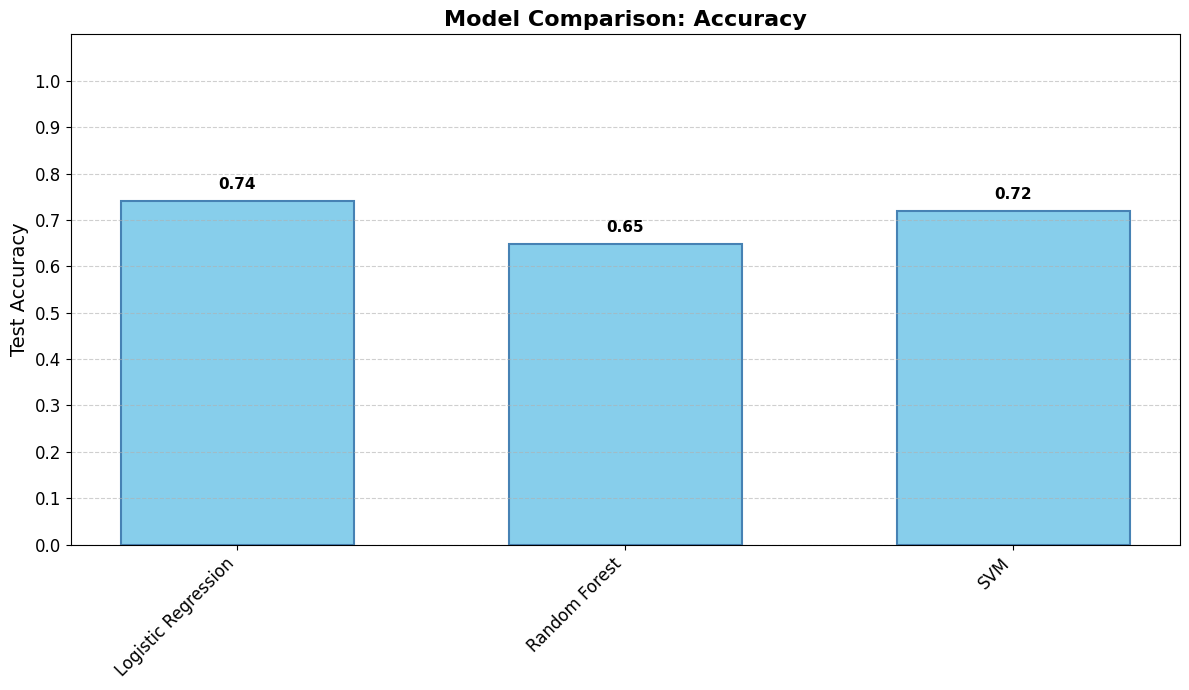

In [27]:
labels = list(results.keys())
overview_scores = [results[m]['Overview Accuracy'] for m in labels]  # Fixed key here

x = np.arange(len(labels))
width = 0.6

plt.figure(figsize=(12, 7))

bars = plt.bar(x, overview_scores, width=width, color='skyblue', edgecolor='steelblue', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f"{height:.2f}", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x, labels, rotation=45, ha='right', fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
plt.ylabel("Test Accuracy", fontsize=14)
plt.title("Model Comparison: Accuracy", fontsize=16, fontweight='bold')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Logistic Regression achieved the best accuracy at 74 %, followed by SVM at 72 %, while the Random Forest model reached 65 %. Given the challenge of predicting film genres from brief plot summaries, these scores are solid overall.

The confusion matrices indicate that misclassifications most frequently occur between Drama and Comedy. This mirrors earlier findings from the DataAnalysis notebook, where both genres displayed very similar language patterns and vocabulary—similarities that evidently make them harder for the models to distinguish.

## LSTM Model

The following approach leverages a Long Short-Term Memory (LSTM) network — a specialized type of Recurrent Neural Network (RNN) designed to handle sequential data such as natural language. LSTMs are capable of learning long-term dependencies by using a system of input, forget, and output gates to regulate the flow of information through memory cells.

### Preprocessing

The input texts are first tokenized using Keras’ `Tokenizer`, which converts them into sequences of integers. The vocabulary is limited to the 10,000 most frequent words. These sequences are then padded to a fixed length of 100 tokens using `pad_sequences`, ensuring that all inputs have the same shape.

The target variable (e.g., genre labels) is encoded using `LabelEncoder` to map string categories to numeric class indices suitable for classification.

### Model Architecture

The model is built using Keras’ `Sequential` API and consists of the following layers:

- **Embedding Layer**: Converts word indices into dense vector representations. The embedding dimension is treated as a tunable hyperparameter.
- **SpatialDropout1D**: Regularizes the embedding output by randomly dropping entire 1D feature maps.
- **BatchNormalization**: Normalizes layer activations to improve training stability and convergence.
- **LSTM Layer**: Learns sequential dependencies with tunable units and dropout parameters.
- **Dense Output Layer**: A softmax-activated layer that outputs a probability distribution across the target classes.

### Hyperparameter Tuning

We use Keras Tuner’s `RandomSearch` to perform hyperparameter optimization. The following parameters are explored:

- Embedding dimension (`embed_dim`)
- Number of LSTM units (`lstm_units`)
- Dropout and recurrent dropout rates
- Learning rate (`learning_rate`)

Each configuration is evaluated using early stopping based on validation accuracy on a validation split of the training set.




In [69]:
def train_lstm_on_text(X_train_texts, X_test_texts, y_train, y_test, name):
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train_texts)
    X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
    X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

    max_len = 100
    X_train_pad = preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len)
    X_test_pad = preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)

    # Label encoding
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)
    num_classes = len(le.classes_)

    def build_lstm_model(hp):
        model = Sequential()
        model.add(layers.Embedding(
            input_dim=10000,
            output_dim=hp.Int('embed_dim', 64, 128, step=64),
            input_length=max_len
        ))
        model.add(layers.SpatialDropout1D(rate=0.3))
        model.add(BatchNormalization())
        model.add(
          layers.LSTM(
            units=hp.Int('lstm_units', 64, 128, step=64),
            dropout=hp.Float('dropout', 0.4, 0.6, step=0.1),
            recurrent_dropout=hp.Float('recurrent_dropout', 0.4, 0.6, step=0.1)
          )
        )
        model.add(layers.Dense(
            num_classes,
            activation='softmax',
            kernel_regularizer=regularizers.l2(1e-4)
        ))
        model.compile(
            optimizer=optimizers.Adam(
                hp.Float('learning_rate', 1e-4, 1e-3, sampling='LOG')
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    tuner = RandomSearch(
        build_lstm_model,
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=1,
        directory='lstm_tuning',
        project_name=f'lstm_{name}'
    )

    tuner.search(
        X_train_pad, y_train_enc,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        verbose=2,
        callbacks=[callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
    )

    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

    best_model = build_lstm_model(best_hp)

    history = best_model.fit(
        X_train_pad, y_train_enc,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=2
    )

    test_loss, test_acc = best_model.evaluate(X_test_pad, y_test_enc, verbose=0)
    print(f"\n{name} - Test Accuracy: {test_acc:.4f}")

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy ({name})')
    plt.legend()
    plt.show()

    y_pred_probs = best_model.predict(X_test_pad)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    return test_acc


Reloading Tuner from lstm_tuning/lstm_overview/tuner0.json
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


595/595 - 151s - 253ms/step - accuracy: 0.2961 - loss: 1.5316 - val_accuracy: 0.4211 - val_loss: 1.2888
Epoch 2/20
595/595 - 146s - 245ms/step - accuracy: 0.4838 - loss: 1.2166 - val_accuracy: 0.5482 - val_loss: 1.1053
Epoch 3/20
595/595 - 146s - 246ms/step - accuracy: 0.5920 - loss: 1.0146 - val_accuracy: 0.6325 - val_loss: 0.9345
Epoch 4/20
595/595 - 146s - 246ms/step - accuracy: 0.6825 - loss: 0.8252 - val_accuracy: 0.6822 - val_loss: 0.8609
Epoch 5/20
595/595 - 146s - 245ms/step - accuracy: 0.7539 - loss: 0.6700 - val_accuracy: 0.6994 - val_loss: 0.8340
Epoch 6/20
595/595 - 146s - 245ms/step - accuracy: 0.7925 - loss: 0.5584 - val_accuracy: 0.7051 - val_loss: 0.8580
Epoch 7/20
595/595 - 146s - 245ms/step - accuracy: 0.8323 - loss: 0.4703 - val_accuracy: 0.7015 - val_loss: 0.8998
Epoch 8/20
595/595 - 146s - 245ms/step - accuracy: 0.8580 - loss: 0.3995 - val_accuracy: 0.7047 - val_loss: 0.9423

overview - Test Accuracy: 0.7067


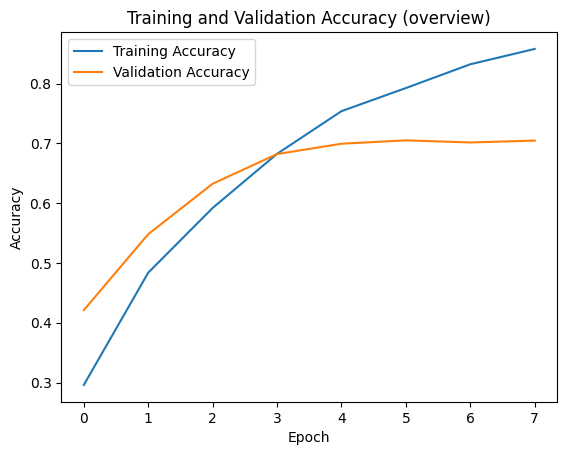

186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step


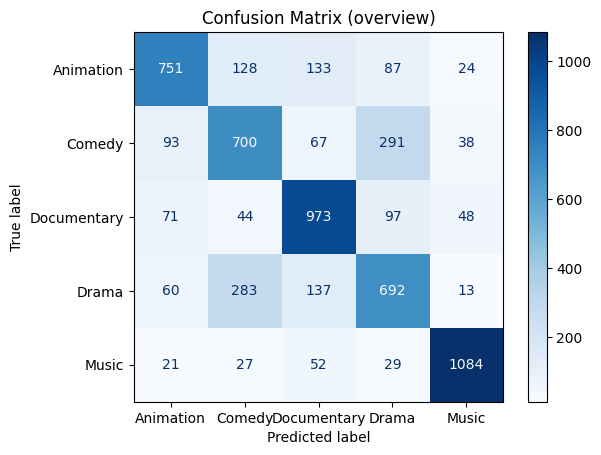

In [70]:
results = {}

results['Overview'] = train_lstm_on_text(X_train_overview, X_test_overview, y_train_overview, y_test_overview, "overview")


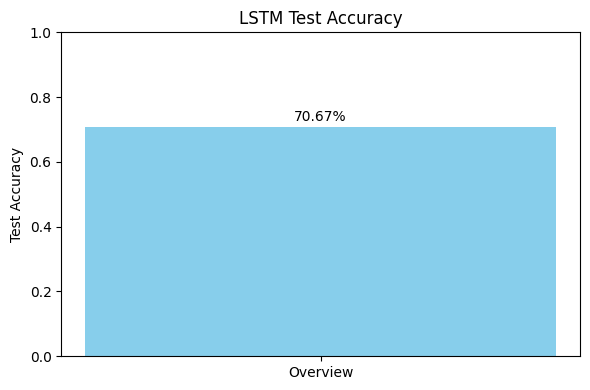

In [71]:
fields = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(6, 4))
bars = plt.bar(fields, accuracies, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('LSTM Test Accuracy')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2%}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



Our LSTM reached a validation accuracy of 70.67 %, trailing both Logistic Regression (74.02 %) and SVM (71.95 %). Like the other models, the LSTM’s confusion matrix shows its biggest trouble spots were the Drama ↔ Comedy pair—evidence that it, too, struggled to learn features that consistently separate those two genres.

We attribute the LSTM’s comparatively weaker result mainly to the limited training set: the model’s many parameters need far more data to generalize well. Under these constraints, shifting to a BERT-based approach is especially attractive, since BERT’s transfer-learning strength can compensate for our small corpus and may improve genre discrimination

## BERT Classification Model

Given the limitations observed with our LSTM model - particularly its sensitivity to dataset size and persistent challenges in distinguishing drama/comedy genres - we turned to BERT (Bidirectional Encoder Representations from Transformers) as a more robust solution. BERT is based on the **Transformer architecture** and was pre-trained on large amounts of text data.

In our case, we use a pre-trained BERT model and **fine-tune** it on our specific classification task to predict the main genre of movie descriptions.

1. **Preprocessing**:
   - The movie descriptions (`overview`) are split into training and validation sets.
   - The genre labels are encoded into numerical values using a `LabelEncoder`.
   - The texts are tokenized using a BERT-compatible tokenizer (`AutoTokenizer`) that automatically handles padding and truncation to a maximum length of 128 tokens.

2. **Dataset and DataLoader**:
   - A custom PyTorch `Dataset` (CustomTextDataset) is created to provide the text-label pairs in the appropriate format.
   - The data is batched using `DataLoader` for efficient GPU processing.

3. **Model Architecture**:
   - The model is based on a pre-trained BERT (`bert-base-uncased`) and includes an additional **classification layer** (dense layer) to output predictions for the target number of genres.
   - A **dropout layer** with a rate of 30% is used for regularization.

4. **Training**:
   - The model is optimized using the `AdamW` optimizer and a linear learning rate scheduler (`get_scheduler`).
   - After each epoch, the model is evaluated on the validation set using the `evaluate` function.
   - To prevent overfitting, **early stopping** is used with a patience of 2 epochs.
   - The best-performing model (based on validation accuracy) is saved and reloaded after training.




In [58]:
def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            batch_labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            preds.extend(predictions.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return acc, preds, labels


In [59]:
class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

def train_bert(
    train_texts, train_labels, val_texts, val_labels,
    num_labels, tokenizer_model="bert-base-uncased",
    epochs=10, patience=2
):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)

    train_dataset = CustomTextDataset(train_texts, train_labels, tokenizer)
    val_dataset = CustomTextDataset(val_texts, val_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    model = AutoModelForSequenceClassification.from_pretrained(
        tokenizer_model,
        num_labels=num_labels,
        hidden_dropout_prob=0.3
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                                 num_warmup_steps=0,
                                 num_training_steps=epochs * len(train_loader))

    best_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()

        val_acc,_,_ = evaluate(model, val_loader, device)
        print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Val Accuracy={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load("best_model.pt"))
    return model, tokenizer


In [60]:
le = LabelEncoder()
df_limited["main_genre_encoded"] = le.fit_transform(df_limited["main_genre"])
labels_encoded = df_limited["main_genre_encoded"].tolist()

text_overview = df_limited["overview"].tolist()

train_texts_ov, val_texts_ov, train_labels_ov, val_labels_ov = train_test_split(
    text_overview, labels_encoded, test_size=0.2, random_state=42
)

print("Training model")
model_ov, tokenizer_ov = train_bert(
    train_texts_ov, train_labels_ov,
    val_texts_ov, val_labels_ov,
    num_labels=len(le.classes_)
)



Training model


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 743/743 [08:01<00:00,  1.54it/s]


Epoch 1: Loss=609.0194, Val Accuracy=0.7781


Epoch 2: 100%|██████████| 743/743 [08:06<00:00,  1.53it/s]


Epoch 2: Loss=416.0312, Val Accuracy=0.7860


Epoch 3: 100%|██████████| 743/743 [08:06<00:00,  1.53it/s]


Epoch 3: Loss=360.3239, Val Accuracy=0.8057


Epoch 4: 100%|██████████| 743/743 [08:06<00:00,  1.53it/s]


Epoch 4: Loss=320.0424, Val Accuracy=0.8092


Epoch 5: 100%|██████████| 743/743 [08:06<00:00,  1.53it/s]


Epoch 5: Loss=289.3905, Val Accuracy=0.8201


Epoch 6: 100%|██████████| 743/743 [08:06<00:00,  1.53it/s]


Epoch 6: Loss=259.2253, Val Accuracy=0.8109


Epoch 7: 100%|██████████| 743/743 [08:06<00:00,  1.53it/s]


Epoch 7: Loss=233.7678, Val Accuracy=0.8075
Early stopping at epoch 7


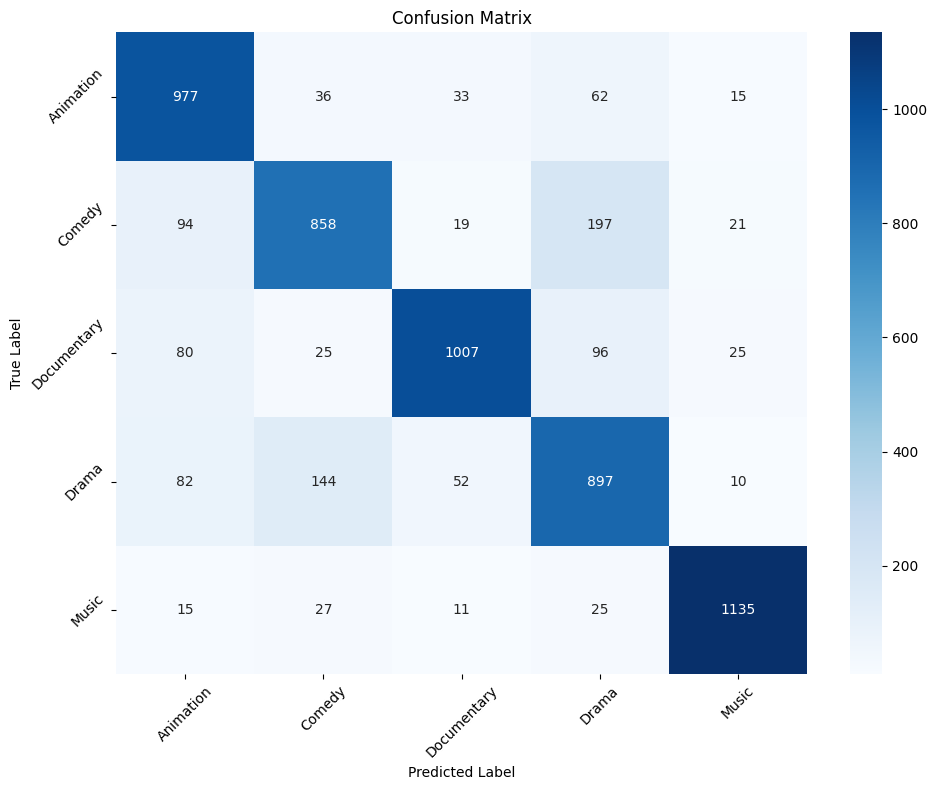

In [61]:
def plot_confusion_matrix(y_true, y_pred, title, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()


val_dataset_ov = CustomTextDataset(val_texts_ov, val_labels_ov, tokenizer_ov)

val_loader_ov = DataLoader(val_dataset_ov, batch_size=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc_ov, preds_ov, labels_ov = evaluate(model_ov, val_loader_ov, device)

labels_ov_text = le.inverse_transform(labels_ov)
preds_ov_text = le.inverse_transform(preds_ov)

plot_confusion_matrix(labels_ov_text, preds_ov_text, title="Confusion Matrix", labels=le.classes_)


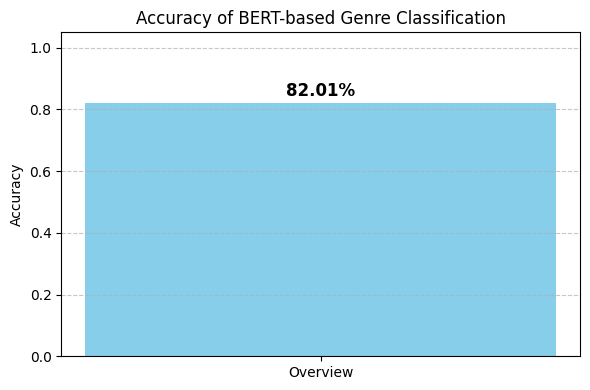

In [63]:
plt.figure(figsize=(6, 4))
bars = plt.bar(["Overview"], [acc_ov], color="skyblue")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2%}",
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Accuracy of BERT-based Genre Classification")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Our fine-tuned BERT model demonstrated strong performance in genre classification, achieving 82.01% accuracy. This result significantly outperformed all other approaches we tested, including traditional machine learning models (SVM, Random Forest, and Logistic Regression) as well as the LSTM neural network architecture.

Interestingly, the model exhibited similar patterns of misclassification to these other approaches, particularly in frequently confusing Drama and Comedy genres.


## Conclusion and Future Work

### Conclusion — addressing RQ-1
*How accurately can genres be inferred from plot texts, and which model performs best?*

Five genre-classification models were evaluated:

| Model                | Accuracy |
|----------------------|----------|
| Logistic Regression  | 74 % |
| SVM                  | 72 % |
| LSTM                 | 71 % |
| Random Forest        | 65 % |
| **BERT**             | **82 %** |

The transformer-based **BERT model achieved the highest accuracy, clearly outperforming all traditional and RNN baselines**.
Nonetheless, every model showed notable confusion between the semantically similar genres **Drama** and **Comedy**, indicating an inherent challenge when relying solely on plot descriptions. Overall, BERT provides the most reliable genre predictions.



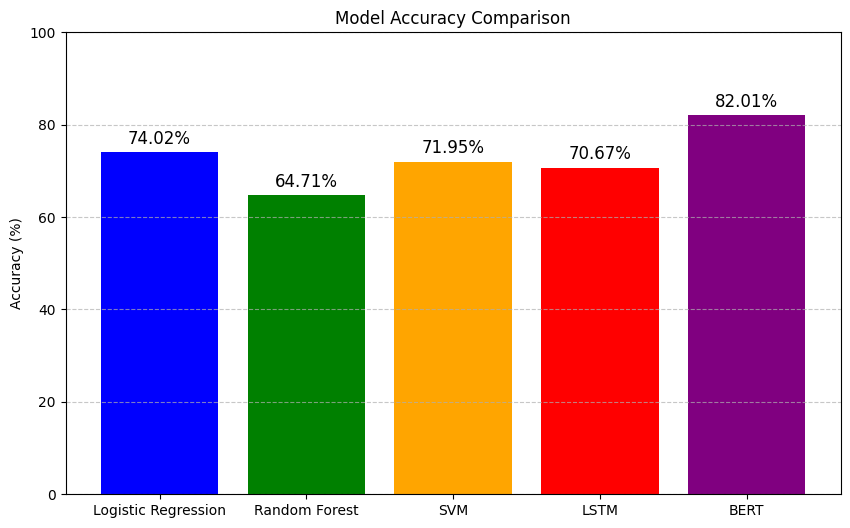

In [72]:
models = ['Logistic Regression', 'Random Forest', 'SVM', 'LSTM', 'BERT']

accuracies = [74.02, 64.71, 71.95, 70.67, 82.01]

plt.figure(figsize=(10,6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])

for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{acc:.2f}%', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Future Work
Several promising directions could further improve classification performance:

1. **Advanced Loss Functions**
   - Implementing triplet loss could help the model better learn subtle distinctions between Drama and Comedy by explicitly optimizing for relative distance metrics between similar and dissimilar examples.

2. **Data Augmentation**
   - Expanding the dataset size, particularly for ambiguous cases
   - Experimenting with longer plot descriptions to provide more contextual information

These enhancements could potentially address the current limitations and push accuracy beyond the 82% benchmark achieved in this work.